# Miner notebook

Purpose: Extract rules from the data using the apriori algorithm

In [1]:
from apyori import apriori

Make some sample transactions to get to know the function

In [2]:
transactions = [
    ['beer', 'diapers'],
    ['diapers', 'milk'],
    ['beer', 'nuts', 'diapers'],    
    ['milk', 'nuts']
]

In [3]:
rec = apriori(transactions, min_confidence=0.8, min_support=0.5)
l = list(rec)

In [4]:
print(l)

[RelationRecord(items=frozenset({'beer', 'diapers'}), support=0.5, ordered_statistics=[OrderedStatistic(items_base=frozenset({'beer'}), items_add=frozenset({'diapers'}), confidence=1.0, lift=1.3333333333333333)])]


Probably need some pretty print for this..

In [5]:
def pprint_records(rec_list):
    r = rec_list.copy()
    for row in r:
        print(f'Items:  {set(row.items)}')
        print(f'Support: {row.support:.4f}')
        print('BODY -> HEAD[Confidence, Lift]\n')
        for os in row.ordered_statistics:
            print(f'\t{set(os.items_base)}  ->  {set(os.items_add)}[{os.confidence:.2f}, {os.lift:.2f}]\n\n')

In [6]:
pprint_records(l)

Items:  {'beer', 'diapers'}
Support: 0.5000
BODY -> HEAD[Confidence, Lift]

	{'beer'}  ->  {'diapers'}[1.00, 1.33]




## Import some real data

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
all_raw = pd.read_csv('cleansed_data//all_consumption_metadata.csv', parse_dates=True, index_col=0,
                     dtype={'loc_id':'str', 'consumption_kvah':'float32', 'temperature':'float32',
                           'el_price':'float32', 'oil_price':'float32'})
all_raw.head()

,loc_id,consumption_kvah,temperature,el_price,oil_price
time,,,,,
2018-01-01 00:00:00,0,27.0,5.5,258.010010,543.415771
2018-01-01 01:00:00,0,27.5,5.0,258.989990,543.415771
2018-01-01 02:00:00,0,27.0,4.8,255.750000,543.415771
2018-01-01 03:00:00,0,23.0,4.9,242.039993,543.415771
2018-01-01 04:00:00,0,23.0,3.7,242.429993,543.415771


In [9]:
all_df = all_raw.copy()

Separate all locations

In [10]:
loc_ids = all_df['loc_id'].unique()

d = {}

for loc in loc_ids: 
    d[loc] = all_df[all_df['loc_id']==loc]
    print(f'Length of {loc}: {len(d[loc])}')

Length of 0: 18385
Length of 1: 18385
Length of 3: 18385
Length of 4: 18385
Length of 6: 18385
Length of 10: 18385
Length of 11: 18385
Length of 12: 18385
Length of 16: 18385
Length of 17: 18385
Length of 18: 18385
Length of 19: 18385
Length of 7: 18344
Length of 8: 16111
Length of 14: 15299
Length of 2: 15134
Length of 5: 14001
Length of 15: 12493
Length of 13: 6090
Length of 9: 11783


13 is probably a nice sample dataset

In [11]:
sample = d['13']

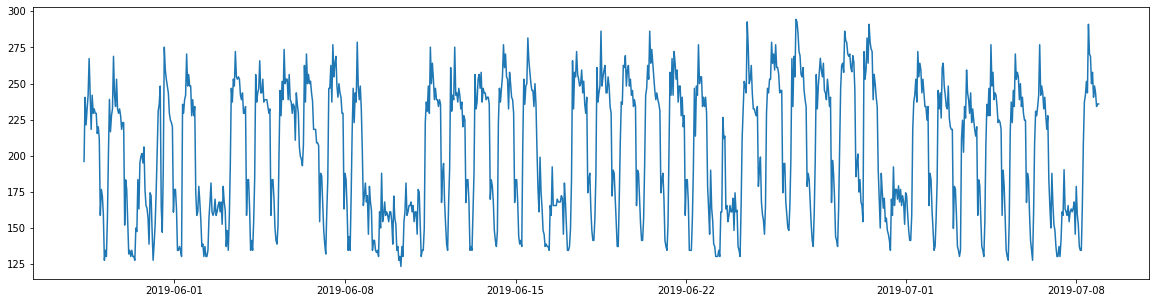

In [13]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(sample['consumption_kvah'][:1000])
plt.show()

Might be, might not be. Considering the distinct even peaks this timeseries is probably not representative of private householdings, but rather some commercial customer.

It should do for prototyping anyway.

**The validity** of the apriori algortithm is heavily dependent on the categorization of numerical values. Probably have to try a few approaches

#### **Test 1**: Bucket all numerical values in percentiles

In [14]:
loc = '13'
sample = d[loc]
sample = sample.drop(['loc_id'], axis=1)

In [15]:
def create_percentile_mask_dict(df, means=None, stds=None):
    
    df_copy = df.copy()
    cols = df_copy.columns
    
    # Use either a supplied means and stds list or extract from the given data
    if means==None: means = [np.mean(df_copy[c]) for c in cols]
    if stds==None: stds = [np.std(df_copy[c]) for c in cols]
        
    masks = {}
    masks['m3std'] = [df_copy[c]<(m-3*s) for c, m, s in zip(cols, means, stds)]
    masks['m2std'] = [(df_copy[c]<(m-2*s)) & ~m3std for c, m, s, m3std in zip(cols, means, stds, masks['m3std'])]
    masks['m1std'] = [(df_copy[c]<(m-s)) & ~(m3std|m2std) for c, m, s, m3std, m2std in zip(cols, means, stds, masks['m3std'], masks['m2std'])]

    masks['m0std'] = [(df_copy[c]<=(m+s)) & ~(m3std|m2std|m1std) for c, m, s, m3std, m2std, m1std 
                 in zip(cols, means, stds, masks['m3std'], masks['m2std'], masks['m1std'])]

    masks['p3std'] = [df_copy[c]>(m+3*s) for c, m, s in zip(cols, means, stds)]
    masks['p2std'] = [(df_copy[c]>(m+2*s)) & ~p3std for c, m, s, p3std in zip(cols, means, stds, masks['p3std'])]
    masks['p1std'] = [(df_copy[c]>(m+s)) & ~(p3std|p2std) for c, m, s, p3std, p2std in zip(cols, means, stds, masks['p3std'], masks['p2std'])]
    
    return masks.copy()

In [16]:
def create_transactions_array(d, n):
    transactions = []
    
    i = 0
    while i < n:
        row = []
        for name, m in d.items():
            for entry in m:
                if entry[i]: row.append(name+'_'+entry.name)
        transactions.append(row)
        i += 1
        
    return transactions

In [17]:
masks = create_percentile_mask_dict(sample)
n = len(masks['m0std'][0])
    
transactions = create_transactions_array(masks, n)

In [18]:
n

6090

Sample is only 6000 rows, so we should be smart about choosing support threshold.

 * Too low threshold might find false rules. Some relationships might happen by chance in a few rows.
 * Finding rules for rare occurrences is not necessarily of value compared to strong everyday rules.
 * Too high threshold might overlook interesting relationships.

 
One much-used example is demanding 50 occurrences over 10,000 rows. I.e. min_support=0.005.

Given the size of our dataset, at 6,000 rows, we'll start out with min_support of 1%. This gives us rules with quite solid grounding.

Playing with confidence and lift to filter out the strongest rules.

In [19]:
min_support = 0.01

In [26]:
rec = apriori(transactions, min_support=min_support, min_confidence=0.6, min_lift=4)
pprint_records(list(rec))

Items:  {'m2std_el_price', 'm1std_oil_price'}
Support: 0.0192
BODY -> HEAD[Confidence, Lift]

	{'m2std_el_price'}  ->  {'m1std_oil_price'}[0.68, 4.56]


Items:  {'p2std_oil_price', 'm1std_temperature'}
Support: 0.0184
BODY -> HEAD[Confidence, Lift]

	{'p2std_oil_price'}  ->  {'m1std_temperature'}[0.67, 4.10]


Items:  {'p1std_consumption_kvah', 'p2std_temperature'}
Support: 0.0110
BODY -> HEAD[Confidence, Lift]

	{'p2std_temperature'}  ->  {'p1std_consumption_kvah'}[0.66, 4.03]


Items:  {'m2std_el_price', 'm0std_consumption_kvah', 'm1std_oil_price'}
Support: 0.0103
BODY -> HEAD[Confidence, Lift]

	{'m2std_el_price', 'm0std_consumption_kvah'}  ->  {'m1std_oil_price'}[0.68, 4.57]


Items:  {'p1std_consumption_kvah', 'm0std_el_price', 'p2std_temperature'}
Support: 0.0108
BODY -> HEAD[Confidence, Lift]

	{'p2std_temperature'}  ->  {'p1std_consumption_kvah', 'm0std_el_price'}[0.65, 5.32]


	{'m0std_el_price', 'p2std_temperature'}  ->  {'p1std_consumption_kvah'}[0.69, 4.27]


Items:  {'m2st

This is our most solid rule with support threshold at 1%. 

In [21]:
rec = apriori(transactions, min_support=min_support, min_confidence=0.6, min_lift=2)
pprint_records(list(rec))

Items:  {'m2std_el_price', 'm1std_oil_price'}
Support: 0.0192
BODY -> HEAD[Confidence, Lift]

	{'m2std_el_price'}  ->  {'m1std_oil_price'}[0.68, 4.56]


Items:  {'p2std_oil_price', 'm1std_temperature'}
Support: 0.0184
BODY -> HEAD[Confidence, Lift]

	{'p2std_oil_price'}  ->  {'m1std_temperature'}[0.67, 4.10]


Items:  {'p1std_consumption_kvah', 'p2std_temperature'}
Support: 0.0110
BODY -> HEAD[Confidence, Lift]

	{'p2std_temperature'}  ->  {'p1std_consumption_kvah'}[0.66, 4.03]


Items:  {'m2std_el_price', 'm0std_consumption_kvah', 'm1std_oil_price'}
Support: 0.0103
BODY -> HEAD[Confidence, Lift]

	{'m2std_el_price', 'm0std_consumption_kvah'}  ->  {'m1std_oil_price'}[0.68, 4.57]


Items:  {'m0std_el_price', 'p2std_oil_price', 'm1std_temperature'}
Support: 0.0163
BODY -> HEAD[Confidence, Lift]

	{'m0std_el_price', 'p2std_oil_price'}  ->  {'m1std_temperature'}[0.64, 3.93]


Items:  {'p1std_consumption_kvah', 'm0std_el_price', 'p2std_temperature'}
Support: 0.0108
BODY -> HEAD[Confidence, 

**Surprising remark**: When temperature $\in (97.7, 99.8)$ percentile, the consumption is typically moderately high.

This could say something about this particular customer, and it's likely that this rule won't hold water for the other locations in general.

### Run percentile mining on `Oilspot_prices` and `Elspot_prices`

Since we only have daily values on oilspot prices, and hourly on elspot, it's probably fair to resample the elspot prices.

In [32]:
oil_el = pd.read_csv('cleansed_data//oil_el.csv', index_col=0, parse_dates=True)

In [35]:
oil_el_days = oil_el.index
oil_el.head(3)

,price_oil,price_el
2018-01-01,543.41580,255.16250
2018-01-02,542.76430,311.53000
2018-01-03,552.40753,276.98834


In [37]:
perc_masks = create_percentile_mask_dict(oil_el)

And we do have a timestamp available, so why not extract some rules from it as well?

In [38]:
def create_date_mask_dict(date_ts, weekday=False, month=False):
    
    df = date_ts.copy().to_frame()
    
    date_col = df.columns[0]
    
    masks = {}
    
    if weekday:
        df['weekday'] = [d.weekday() for d in df[date_col]]
        
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

        for i, day in enumerate(weekdays):
            masks[day] = [df['weekday']==i]
            
    if month:
        df['month'] = [d.month for d in df[date_col]]
        
        months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                  'August', 'September', 'October', 'November', 'December']
        
        for i, m in enumerate(months):
            masks[m] = [df['month']==i]
        
    return masks.copy()

In [39]:
date_masks = create_date_mask_dict(oil_el_days, weekday=True, month=False)

In [40]:
all_masks = date_masks.copy()
all_masks.update(perc_masks)

In [41]:
n = len(date_masks['Monday'][0])
n

855

In [42]:
transactions = create_transactions_array(all_masks, n)

Here again is time to be smart about the length of the data. It's quite short (800 rows), so demanding 5% support is probably not a bad idea. That is, at least 40 rows must contain our frequent itemset.

In [43]:
min_support = 0.05

In [45]:
rec = apriori(transactions, min_support=min_support, min_confidence=0.8, min_lift=1.1)
pprint_records(list(rec))

Items:  {'p1std_price_oil', 'm0std_price_el'}
Support: 0.0526
BODY -> HEAD[Confidence, Lift]

	{'p1std_price_oil'}  ->  {'m0std_price_el'}[0.85, 1.16]


Items:  {'Friday_weekday', 'm0std_price_oil', 'm0std_price_el'}
Support: 0.0994
BODY -> HEAD[Confidence, Lift]

	{'Friday_weekday', 'm0std_price_oil'}  ->  {'m0std_price_el'}[0.81, 1.10]


Items:  {'m0std_price_oil', 'm0std_price_el', 'Monday_weekday'}
Support: 0.0982
BODY -> HEAD[Confidence, Lift]

	{'m0std_price_oil', 'Monday_weekday'}  ->  {'m0std_price_el'}[0.82, 1.11]


Items:  {'Saturday_weekday', 'm0std_price_oil', 'm0std_price_el'}
Support: 0.0994
BODY -> HEAD[Confidence, Lift]

	{'Saturday_weekday', 'm0std_price_oil'}  ->  {'m0std_price_el'}[0.81, 1.10]


Items:  {'m0std_price_oil', 'Sunday_weekday', 'm0std_price_el'}
Support: 0.0982
BODY -> HEAD[Confidence, Lift]

	{'Sunday_weekday', 'm0std_price_el'}  ->  {'m0std_price_oil'}[0.94, 1.11]


Items:  {'Wednesday_weekday', 'm0std_price_oil', 'm0std_price_el'}
Support: 0.0947
BODY

Few strong connections here. A lift above one means there is a definite value to the rule. What we seem to get from this is that typical oil prices typically imply typical el prices. But the buckets are defined to be largest at the typical values anyway. And the low lift implies that typical values are prevalent anyway.

Might dare to lower support a bit. 2.5% support means 20 rows must contain the itemset.

In [46]:
min_support = 0.025

In [47]:
rec = apriori(transactions, min_support=min_support, min_confidence=0.8, min_lift=1.2)
pprint_records(list(rec))

Items:  {'m2std_price_el', 'm3std_price_oil'}
Support: 0.0409
BODY -> HEAD[Confidence, Lift]

	{'m3std_price_oil'}  ->  {'m2std_price_el'}[1.00, 10.96]




In [48]:
n*0.0266

22.743

Cool! So, 22 rows seem to definitely imply that a very strong drop in oil prices drew el prices down as well!

This is the strongest rule by far for this support. No other rule is even above lift 1.2.

This is somewhat interesting given the fact that 98% of Norway's electricity production is renewable, but we're of course not detached from trade either.

Any difference if we use the stds and means from the merged data?

In [49]:
perc_masks = create_percentile_mask_dict(oil_el)
all_masks = date_masks.copy()
all_masks.update(perc_masks)
transactions = create_transactions_array(all_masks, n)

In [50]:
rec = apriori(transactions, min_support=min_support, min_confidence=0.8, min_lift=1.2)
pprint_records(list(rec))

Items:  {'m2std_price_el', 'm3std_price_oil'}
Support: 0.0409
BODY -> HEAD[Confidence, Lift]

	{'m3std_price_oil'}  ->  {'m2std_price_el'}[1.00, 10.96]




Nope. We'll use the characteristics of the merged data from now on, to have a fair comparison.

### How 'bout weather and el prices?

In [51]:
w = pd.read_csv('cleansed_data//Weather.csv', index_col=[0,1], 
                dtype={'temperature':'float32', 'weather_station':'str'}, parse_dates=True)
w.head(3)

,,temperature
,weather_station,
2018-01-01 00:00:00,SN35210,-0.3
2018-01-01 01:00:00,SN35210,-0.5
2018-01-01 02:00:00,SN35210,-1.4


Let's make one complete temperature series using the median measurement in Agder for this one.

In [52]:
first_date = min(w.index.get_level_values(0))
last_date = max(w.index.get_level_values(0))
median_temps = pd.DataFrame(index=pd.date_range(start=first_date, end=last_date, freq='H'), columns=['temperature'])

In [53]:
median_temps['temperature'] = [np.nanmedian(w.loc[idx]) for idx in median_temps.index]

In [54]:
median_temps.head()

,temperature
2018-01-01 00:00:00,5.5
2018-01-01 01:00:00,5.0
2018-01-01 02:00:00,4.8
2018-01-01 03:00:00,4.9
2018-01-01 04:00:00,4.7


In [55]:
median_temps['day'] = median_temps.index.date

In [56]:
temp_el = median_temps.merge(elspot_raw, how='inner', left_index=True, right_index=True)

In [57]:
temp_el_days = temp_el['day']
temp_el = temp_el.drop('day', axis=1)

In [58]:
temp_el.head()

,temperature,price
2018-01-01 00:00:00,5.5,258.010010
2018-01-01 01:00:00,5.0,258.989990
2018-01-01 02:00:00,4.8,255.750000
2018-01-01 03:00:00,4.9,242.039993
2018-01-01 04:00:00,4.7,242.429993


In [59]:
perc_masks = create_percentile_mask_dict(temp_el)
date_masks = create_date_mask_dict(temp_el_days, weekday=True, month=True)

all_masks = date_masks.copy()
all_masks.update(perc_masks)

n = len(perc_masks['m0std'][0])
transactions = create_transactions_array(all_masks, n)

In [60]:
n

18960

19,000 rows. Demanding first 0.005% support first, i.e. ~95 rows back our itemset.

In [61]:
min_support = 0.005

In [62]:
rec = apriori(transactions, min_support=min_support, min_confidence=0.8, min_lift=10)
pprint_records(list(rec))

Items:  {'August_month', 'p1std_price', 'p2std_temperature'}
Support: 0.0080
BODY -> HEAD[Confidence, Lift]

	{'p2std_temperature', 'p1std_price'}  ->  {'August_month'}[0.96, 12.18]


Items:  {'March_month', 'm2std_price', 'Saturday_weekday', 'm0std_temperature'}
Support: 0.0060
BODY -> HEAD[Confidence, Lift]

	{'Saturday_weekday', 'm2std_price'}  ->  {'March_month', 'm0std_temperature'}[0.86, 13.70]




Some suspicious rules here. You're much more likely to be in August month if the temperatures are really high and the el prices are moderately high. Not that surprising. Also, if you happen to find yourself on a Saturday when prices are really low, you're much more likely than elsewhen to find out that the month is March and the temperature is moderate!

Skipping weekdays and months and going down to 0.0025% support, i.e. 50 rows.

In [63]:
transactions = create_transactions_array(perc_masks, n)

In [64]:
min_support = 0.0025

In [65]:
rec = apriori(transactions, min_support=min_support, min_confidence=0.6, min_lift=1.4)
pprint_records(list(rec))

Items:  {'m3std_price', 'm0std_temperature'}
Support: 0.0035
BODY -> HEAD[Confidence, Lift]

	{'m3std_price'}  ->  {'m0std_temperature'}[0.96, 1.50]


Items:  {'p2std_price', 'm1std_temperature'}
Support: 0.0052
BODY -> HEAD[Confidence, Lift]

	{'p2std_price'}  ->  {'m1std_temperature'}[0.71, 4.31]


Items:  {'p3std_price', 'm1std_temperature'}
Support: 0.0049
BODY -> HEAD[Confidence, Lift]

	{'p3std_price'}  ->  {'m1std_temperature'}[0.87, 5.26]




Based of some ~60 rows found with both normal temperature and really low el prices, it seems that your best bet on temperature is that it is normal if prices are high. Furthermore, with the support of ~100 rows, it seems that temperatures during high prices are moderately low. 

This does not imply that low temperatures drive prices up, though. It can very well be the case that prices are mostly normal during colder times, but that when high prices occur, it's usually moderately cold.

Summary thus far:
 * Strong indication that extremely low oil prices drive down el prices substantially.
 * In times of very high el prices, the weather is much more likely to be cold than elsewhen.

## Consumption and el prices?

Using local weather and el prices at hourly frequency. All datasets should agree upon what's a low, medium and high el price.

In [66]:
first_date = min(all_raw.index)
last_date = max(all_raw.index)

el_price_subset = elspot_raw.loc[pd.date_range(start=first_date, end=last_date, freq='H')]

el_subset_mean = np.mean(el_price_subset['price'])
el_subset_std = np.std(el_price_subset['price'])

In [67]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy()
        
    df_copy = df_copy.drop(['loc_id', 'oil_price', 'temperature'], axis=1)
    
    means = [np.mean(df_copy['consumption_kvah']), el_subset_mean]
    stds = [np.std(df_copy['consumption_kvah']), el_subset_std]
    
    perc_masks = create_percentile_mask_dict(df_copy, means=means, stds=stds)
    
    n = len(perc_masks['m0std'][0])
    trans = create_transactions_array(perc_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [68]:
n = len(transactions_wo_loc_id)
n

329875

That's 330,000 transactions! The apriori algorithm does not like very low thresholds, but we'll give this a shot.

Let's start out moderately easy. 0.01% support means at least 3300 rows back us.

Loc ids will probably not enter the equation before we lower the support threshold to find more specific rule. For now we'll keep them in a separated set of transactions to keep them off our results. Any general rules?

In [69]:
min_support = 0.01

This high support threshold yields itemsets that are valid for (supported by) many rows. They might not yield extraordinary value since these occurrences are typical anyway. Thus the lift is low.

In [70]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.05)
pprint_records(list(rec))

Items:  {'m0std_el_price', 'm0std_consumption_kvah'}
Support: 0.4704
BODY -> HEAD[Confidence, Lift]

	{'m0std_consumption_kvah'}  ->  {'m0std_el_price'}[0.75, 1.06]


	{'m0std_el_price'}  ->  {'m0std_consumption_kvah'}[0.67, 1.06]


Items:  {'m2std_el_price', 'm0std_consumption_kvah'}
Support: 0.0163
BODY -> HEAD[Confidence, Lift]

	{'m2std_el_price'}  ->  {'m0std_consumption_kvah'}[0.68, 1.08]




Too general. All we have here is basically that what we usually see is the usual. 

Do we see any strong patterns for the different locations?

In [71]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Items:  {'loc_4', 'm0std_consumption_kvah', 'm0std_el_price'}
Support: 0.0303
BODY -> HEAD[Confidence, Lift]

	{'loc_4', 'm0std_el_price'}  ->  {'m0std_consumption_kvah'}[0.77, 1.22]




Location 4 is the customer that the fact of there being moderate el prices increases the proability of having a moderate consumption.

In [72]:
min_support = 0.001

In [73]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.5)
pprint_records(list(rec))

Items:  {'m2std_consumption_kvah', 'loc_14', 'm0std_el_price'}
Support: 0.0011
BODY -> HEAD[Confidence, Lift]

	{'m2std_consumption_kvah', 'm0std_el_price'}  ->  {'loc_14'}[0.60, 12.97]




In [74]:
0.0010 * n

329.875

0.1% support means we need at least 330 rows to back the itemset. If you observe moderate prices and low consumption, you have a tremendous increase in probability that the location at which this happens is 14. This could also mean that location 14 is one of the few which has data in this period, though.

In [75]:
min_support = 0.0005
min_support * n

164.9375

In [76]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.15)
pprint_records(list(rec))

In [77]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.4)
pprint_records(list(rec))

Items:  {'m2std_consumption_kvah', 'loc_14', 'm0std_el_price'}
Support: 0.0011
BODY -> HEAD[Confidence, Lift]

	{'m2std_consumption_kvah', 'm0std_el_price'}  ->  {'loc_14'}[0.60, 12.97]


Items:  {'m2std_el_price', 'm0std_consumption_kvah', 'loc_15'}
Support: 0.0009
BODY -> HEAD[Confidence, Lift]

	{'m2std_el_price', 'loc_15'}  ->  {'m0std_consumption_kvah'}[0.90, 1.42]




At loc 15, when prices are very low, you're very likely to find that they have moderate consumption. Lift implies more so than elsewhen.

In [78]:
m, s = np.mean(d['15']['consumption_kvah']), np.std(d['15']['consumption_kvah'])
print(f'Normal consumption for 15 is between {m-s:.0f} and {m+s:.0f}')
print(f'Low prices are between {el_subset_mean-2*el_subset_std:.0f} and {el_subset_mean-3*el_subset_std:.0f}')

Normal consumption for 15 is between 6 and 13
Low prices are between 209 and 116


In [79]:
mask_1 = d['15']['consumption_kvah'] > 6
mask_2 = d['15']['consumption_kvah'] < 13
mask_3 = mask_1 & mask_2

mask_4 = el_price_subset['price'] < 21
mask_5 = el_price_subset['price'] > 12
mask_6 = mask_4 & mask_5

mask_7 = mask_6 & mask_3

In [80]:
start = d['15'].index[0]
end = d['15'].index[-1]

In [81]:
period = pd.date_range(start=start, end=end, freq='H')

c:\users\arild\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


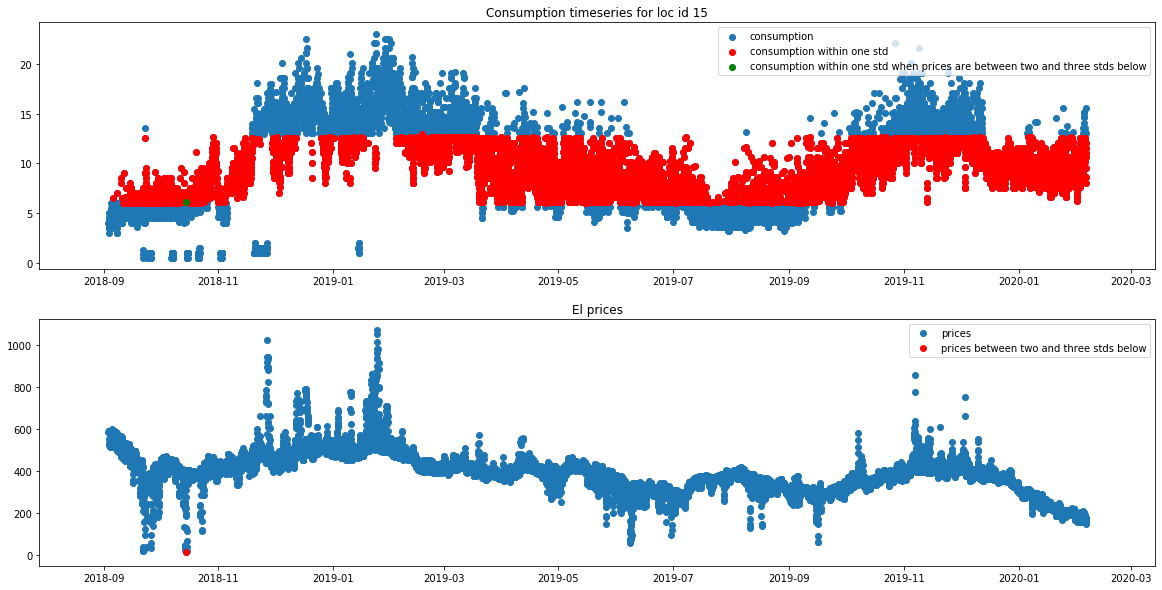

In [82]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(period, d['15'].loc[period]['consumption_kvah'], label='consumption')
ax[0].scatter(period, pd.DataFrame(index=period, data=d['15'][mask_3])['consumption_kvah'], c='r', label='consumption within one std')
ax[0].scatter(period, pd.DataFrame(index=period, data=d['15'][mask_7])['consumption_kvah'], c='g', label='consumption within one std when prices are between two and three stds below')
ax[0].set_title('Consumption timeseries for loc id 15')

ax[1].set_title('El prices')
ax[1].scatter(period, el_price_subset.loc[period], label='prices')
ax[1].scatter(period, pd.DataFrame(index=period, data=el_price_subset[mask_6])['price'], c='r', label='prices between two and three stds below')

ax[0].legend()
ax[1].legend()

plt.show()

This customer does indeed have some, though not very much, fluctuations in usage, and they are at normal levels when prices are low. However, they have also high consumption when prices are high.

It could be useful to base the numbers on weekly or daily averages instead of overall averages and deviations.

In [83]:
m, s = np.mean(d['14']['consumption_kvah']), np.std(d['14']['consumption_kvah'])

print(f'Minus 2 stds consumption for 14 is between {m-2*s:.0f} and {max(0,m-3*s):.0f}')
print(f'Normal prices are between {el_subset_mean-el_subset_std:.0f} and {el_subset_mean+el_subset_std:.0f}')

Minus 2 stds consumption for 14 is between 4 and 0
Normal prices are between 301 and 486


c:\users\arild\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


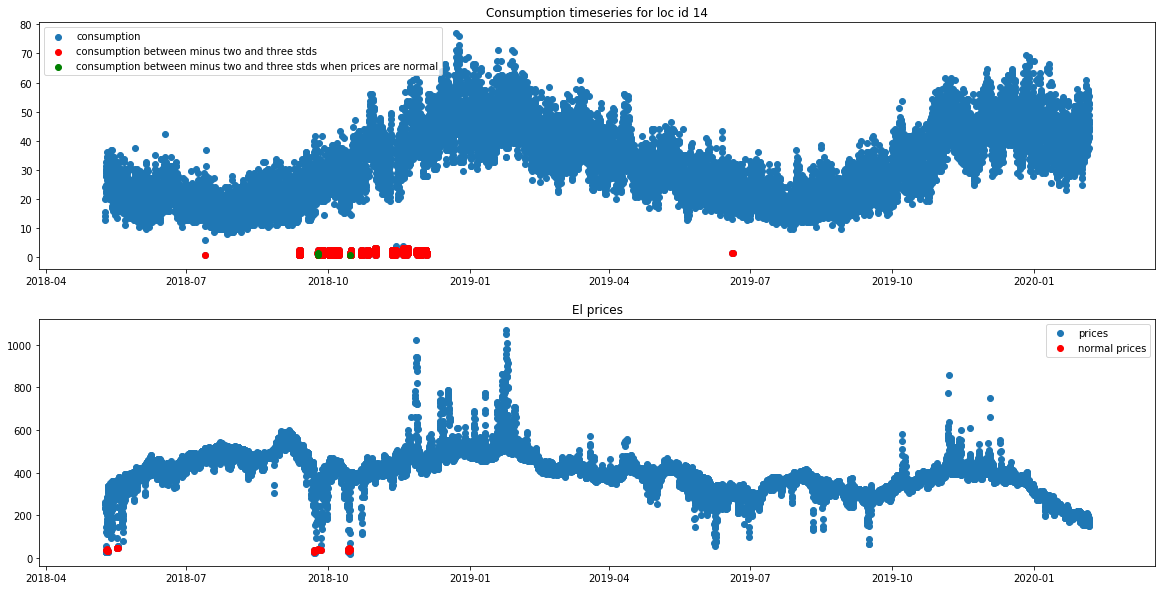

In [84]:
mask_1 = d['14']['consumption_kvah'] > 0
mask_2 = d['14']['consumption_kvah'] < 4
mask_3 = mask_1 & mask_2

mask_4 = el_price_subset['price'] < 50
mask_5 = el_price_subset['price'] > 31
mask_6 = mask_4 & mask_5

mask_7 = mask_6 & mask_3

start = d['14'].index[0]
end = d['14'].index[-1]

period = pd.date_range(start=start, end=end, freq='H')


fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].scatter(period, d['14'].loc[period]['consumption_kvah'], label='consumption')
ax[0].scatter(period, pd.DataFrame(index=period, data=d['14'][mask_3])['consumption_kvah'], c='r', label='consumption between minus two and three stds')
ax[0].scatter(period, pd.DataFrame(index=period, data=d['14'][mask_7])['consumption_kvah'], c='g', label='consumption between minus two and three stds when prices are normal')
ax[0].set_title('Consumption timeseries for loc id 14')

ax[1].set_title('El prices')
ax[1].scatter(period, el_price_subset.loc[period], label='prices')
ax[1].scatter(period, pd.DataFrame(index=period, data=el_price_subset[mask_6])['price'], c='r', label='normal prices')

ax[0].legend()
ax[1].legend()

plt.show()

What we see here is that loc 14 has timeseries with missing values, or simply down time on their transformers. Nothing worth mentioning.

## Desperately need other categories!

Compare prices and consumption to last week's value at this time.

How to do this: 
 * Decide how fine resolution (n) you want for bucket size.
 * For each column, define n buckets between min and max value of that column.
 * Compare last week's bucket from this. (Last week I was in bucket 3, this week in bucket 5) -> The category is +2

In [85]:
np.arange(0.5,11, (11-0.5)/5)

array([0.5, 2.6, 4.7, 6.8, 8.9])

In [86]:
def create_shift_diff_mask_dict(df, n_buckets=10, shift=24*7, label='lw'):
    
    df_copy = df.copy()
    cols = df_copy.columns
        
    masks = {}
    
    shifted = df_copy.shift(shift)
    shifted = shifted.dropna()
    df_copy = df_copy.loc[shifted.index]
        
    diffs = pd.DataFrame(index=df_copy.index)
    
    for c in cols: 
        maxim = max(df_copy[c])
        minim = min(df_copy[c])

        arange = np.arange(minim, maxim, (maxim-minim)/n_buckets)

        old = pd.DataFrame(index=shifted.index, columns=['bucket'], data=0)
        new = pd.DataFrame(index=df_copy.index, columns=['bucket'], data=0)

        for i, r in enumerate(arange):
            old[shifted[c]>r] = i 
            new[df_copy[c]>r] = i
            
        diffs[c] = new['bucket'] - old['bucket'] 
     
    
    for n in range(-n_buckets+1, 0):
        masks[f'm{(100/n_buckets * n*(-1)):.0f}'] = [diffs[c]==n for c in cols]
    
    for n in range(0, n_buckets):
        masks[f'p{(100/n_buckets * n):.0f}'] = [diffs[c]==n for c in cols]
        
    return masks

In [87]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=20, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [88]:
n = len(transactions_wo_loc_id)

In [89]:
min_support = 0.005
min_support*n

9.785

In [90]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.7, min_lift=1.2)
pprint_records(list(rec))

Items:  {'m20_el_price', 'm5_temperature'}
Support: 0.0092
BODY -> HEAD[Confidence, Lift]

	{'m20_el_price'}  ->  {'m5_temperature'}[0.86, 4.41]


Items:  {'p5_el_price', 'm25_temperature'}
Support: 0.0066
BODY -> HEAD[Confidence, Lift]

	{'m25_temperature'}  ->  {'p5_el_price'}[0.72, 3.29]




In [91]:
min_support = 0.0075
min_support*n

14.6775

In [92]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.7, min_lift=1.15)
pprint_records(list(rec))

Items:  {'m20_el_price', 'm5_temperature'}
Support: 0.0092
BODY -> HEAD[Confidence, Lift]

	{'m20_el_price'}  ->  {'m5_temperature'}[0.86, 4.41]




In [93]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'el_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [94]:
min_support = 0.005
min_support*n

0.35000000000000003

In [95]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Items:  {'p0_consumption_kvah', 'p0_temperature'}
Support: 0.2253
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.61, 1.26]




In [96]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'el_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=15, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [97]:
min_support = 0.005
min_support*n

0.35000000000000003

In [98]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.15)
pprint_records(list(rec))

Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_0'}
Support: 0.0082
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_0'}  ->  {'p0_consumption_kvah'}[0.67, 1.87]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_1'}
Support: 0.0118
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_1'}  ->  {'p0_consumption_kvah'}[0.68, 1.89]


Items:  {'p7_consumption_kvah', 'm7_temperature', 'loc_10'}
Support: 0.0056
BODY -> HEAD[Confidence, Lift]

	{'p7_consumption_kvah', 'loc_10'}  ->  {'m7_temperature'}[0.61, 2.62]


Items:  {'p7_consumption_kvah', 'm13_temperature', 'loc_2'}
Support: 0.0051
BODY -> HEAD[Confidence, Lift]

	{'m13_temperature', 'loc_2'}  ->  {'p7_consumption_kvah'}[0.67, 3.29]


Items:  {'p0_consumption_kvah', 'loc_4', 'p0_temperature'}
Support: 0.0061
BODY -> HEAD[Confidence, Lift]

	{'loc_4', 'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.67, 1.87]


Items:  {'p0_consumption_kvah', 'loc_4', 'p7_temperature'}
Support: 0.0056
BODY -> HEAD[Confidence, L

In [99]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'el_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [100]:
n = len(transactions_wo_loc_id)
min_support = 0.005
min_support*n

9.785

In [101]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.7, min_lift=1.2)
pprint_records(list(rec))

Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_1'}
Support: 0.0169
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_1'}  ->  {'p0_consumption_kvah'}[0.73, 1.52]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_17'}
Support: 0.0153
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_17'}  ->  {'p0_consumption_kvah'}[0.81, 1.68]


Items:  {'p0_consumption_kvah', 'loc_6', 'p0_temperature'}
Support: 0.0148
BODY -> HEAD[Confidence, Lift]

	{'loc_6', 'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.71, 1.46]


Items:  {'p0_consumption_kvah', 'loc_8', 'p0_temperature'}
Support: 0.0118
BODY -> HEAD[Confidence, Lift]

	{'loc_8', 'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.74, 1.54]


Items:  {'loc_9', 'p0_consumption_kvah', 'p0_temperature'}
Support: 0.0082
BODY -> HEAD[Confidence, Lift]

	{'loc_9', 'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.73, 1.51]




In [102]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Items:  {'p0_consumption_kvah', 'p0_temperature'}
Support: 0.2253
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.61, 1.26]




In [103]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'el_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=2)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [104]:
n = len(transactions_wo_loc_id)
min_support = 0.005
min_support*n

9.685

In [105]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_1'}
Support: 0.0119
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_1'}  ->  {'p0_consumption_kvah'}[0.66, 1.72]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_15'}
Support: 0.0057
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_15'}  ->  {'p0_consumption_kvah'}[0.65, 1.70]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_17'}
Support: 0.0088
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_17'}  ->  {'p0_consumption_kvah'}[0.63, 1.65]


Items:  {'loc_18', 'p0_consumption_kvah', 'p0_temperature'}
Support: 0.0103
BODY -> HEAD[Confidence, Lift]

	{'loc_18', 'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.65, 1.69]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_19'}
Support: 0.0114
BODY -> HEAD[Confidence, Lift]

	{'p0_consumption_kvah', 'loc_19'}  ->  {'p0_temperature'}[0.65, 2.28]


Items:  {'p10_temperature', 'p0_consumption_kvah', 'loc_2'}
Support: 0.0077
BODY -> HEAD[Confiden

Resample per day, look at yesterday

In [106]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'el_price'], axis=1).resample(rule='D').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=20, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [107]:
n = len(transactions_wo_loc_id)
min_support = 0.005
min_support*n

68.74

In [108]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Items:  {'p0_consumption_kvah', 'loc_4', 'p0_temperature'}
Support: 0.0115
BODY -> HEAD[Confidence, Lift]

	{'loc_4', 'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.61, 1.63]




In [109]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'temperature'], axis=1).resample(rule='D').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=20, shift=7)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [110]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.1)
pprint_records(list(rec))

In [111]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price'], axis=1).resample(rule='M').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [112]:
n = len(transactions_wo_loc_id)
min_support = 0.02
min_support*n

9.0

In [113]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.9, min_lift=2)
pprint_records(list(rec))

Items:  {'p10_temperature', 'm40_el_price'}
Support: 0.0400
BODY -> HEAD[Confidence, Lift]

	{'m40_el_price'}  ->  {'p10_temperature'}[0.95, 3.84]




In [114]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.9, min_lift=2)
pprint_records(list(rec))

Items:  {'p10_temperature', 'm40_el_price'}
Support: 0.0400
BODY -> HEAD[Confidence, Lift]

	{'m40_el_price'}  ->  {'p10_temperature'}[0.95, 3.84]




In [115]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'temperature'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=20, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [116]:
n = len(transactions_wo_loc_id)
min_support = 0.01
min_support*n

19.57

In [117]:
n

1957

In [118]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.95, min_lift=1.5)
pprint_records(list(rec))

In [119]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [120]:
n = len(transactions_with_loc_id)
n

1957

In [121]:
min_support = 0.01
min_support*n

19.57

In [122]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.5)
pprint_records(list(rec))

Items:  {'p20_el_price', 'm10_temperature'}
Support: 0.0245
BODY -> HEAD[Confidence, Lift]

	{'p20_el_price'}  ->  {'m10_temperature'}[0.66, 2.52]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_1'}
Support: 0.0169
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_1'}  ->  {'p0_consumption_kvah'}[0.73, 1.52]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_17'}
Support: 0.0153
BODY -> HEAD[Confidence, Lift]

	{'p0_consumption_kvah', 'loc_17'}  ->  {'p0_temperature'}[0.60, 1.62]


	{'p0_temperature', 'loc_17'}  ->  {'p0_consumption_kvah'}[0.81, 1.68]


Items:  {'p0_consumption_kvah', 'loc_8', 'p0_temperature'}
Support: 0.0118
BODY -> HEAD[Confidence, Lift]

	{'loc_8', 'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.74, 1.54]


Items:  {'m20_temperature', 'p20_consumption_kvah', 'p0_el_price'}
Support: 0.0123
BODY -> HEAD[Confidence, Lift]

	{'m20_temperature', 'p20_consumption_kvah'}  ->  {'p0_el_price'}[0.83, 1.72]


Items:  {'p0_consumption_kvah', 'p0_temperat

In [123]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Items:  {'p20_el_price', 'm10_temperature'}
Support: 0.0245
BODY -> HEAD[Confidence, Lift]

	{'p20_el_price'}  ->  {'m10_temperature'}[0.66, 2.52]


Items:  {'p0_consumption_kvah', 'p0_temperature'}
Support: 0.2253
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.61, 1.26]


Items:  {'m10_consumption_kvah', 'p0_temperature', 'p0_el_price'}
Support: 0.0332
BODY -> HEAD[Confidence, Lift]

	{'m10_consumption_kvah', 'p0_temperature'}  ->  {'p0_el_price'}[0.62, 1.28]


Items:  {'m20_temperature', 'p20_consumption_kvah', 'p0_el_price'}
Support: 0.0123
BODY -> HEAD[Confidence, Lift]

	{'m20_temperature', 'p20_consumption_kvah'}  ->  {'p0_el_price'}[0.83, 1.72]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'p0_el_price'}
Support: 0.1288
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'p0_el_price'}  ->  {'p0_consumption_kvah'}[0.62, 1.28]




In [124]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'el_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=20, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [125]:
min_support = 0.01
min_support*len(transactions_wo_loc_id)

19.57

In [126]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.15)
pprint_records(list(rec))

In [127]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'consumption_kvah', 'oil_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=20, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [128]:
min_support = 0.005
min_support*len(transactions_wo_loc_id)

9.785

In [129]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.3)
pprint_records(list(rec))

Items:  {'p25_el_price', 'm10_temperature'}
Support: 0.0061
BODY -> HEAD[Confidence, Lift]

	{'p25_el_price'}  ->  {'m10_temperature'}[0.63, 4.43]


Items:  {'m20_el_price', 'm5_temperature'}
Support: 0.0092
BODY -> HEAD[Confidence, Lift]

	{'m20_el_price'}  ->  {'m5_temperature'}[0.86, 4.41]


Items:  {'p5_el_price', 'm25_temperature'}
Support: 0.0066
BODY -> HEAD[Confidence, Lift]

	{'m25_temperature'}  ->  {'p5_el_price'}[0.72, 3.29]




In [130]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'consumption_kvah', 'oil_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [131]:
min_support = 0.005
min_support*len(transactions_wo_loc_id)

9.785

In [132]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Items:  {'p20_el_price', 'm10_temperature'}
Support: 0.0245
BODY -> HEAD[Confidence, Lift]

	{'p20_el_price'}  ->  {'m10_temperature'}[0.66, 2.52]


Items:  {'p0_temperature', 'm30_el_price'}
Support: 0.0082
BODY -> HEAD[Confidence, Lift]

	{'m30_el_price'}  ->  {'p0_temperature'}[0.89, 2.40]


Items:  {'m30_temperature', 'p0_el_price'}
Support: 0.0051
BODY -> HEAD[Confidence, Lift]

	{'m30_temperature'}  ->  {'p0_el_price'}[0.83, 1.73]




In [133]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'consumption_kvah', 'temperature'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [134]:
min_support = 0.005
min_support*len(transactions_wo_loc_id)

9.785

In [135]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Items:  {'m10_oil_price', 'm20_el_price'}
Support: 0.0102
BODY -> HEAD[Confidence, Lift]

	{'m20_el_price'}  ->  {'m10_oil_price'}[0.91, 3.45]


Items:  {'m30_el_price', 'p0_oil_price'}
Support: 0.0092
BODY -> HEAD[Confidence, Lift]

	{'m30_el_price'}  ->  {'p0_oil_price'}[1.00, 2.26]


Items:  {'p20_oil_price', 'p0_el_price'}
Support: 0.0174
BODY -> HEAD[Confidence, Lift]

	{'p20_oil_price'}  ->  {'p0_el_price'}[0.97, 2.01]




In [136]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'el_price', 'temperature'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [137]:
min_support = 0.005
min_support*len(transactions_wo_loc_id)

9.785

In [138]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.1)
pprint_records(list(rec))

In [139]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'temperature'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [140]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.1)
pprint_records(list(rec))

Items:  {'p0_consumption_kvah', 'm20_el_price'}
Support: 0.0077
BODY -> HEAD[Confidence, Lift]

	{'m20_el_price'}  ->  {'p0_consumption_kvah'}[0.68, 1.41]


Items:  {'p0_consumption_kvah', 'm30_el_price'}
Support: 0.0077
BODY -> HEAD[Confidence, Lift]

	{'m30_el_price'}  ->  {'p0_consumption_kvah'}[0.83, 1.73]


Items:  {'p30_consumption_kvah', 'p0_el_price'}
Support: 0.0082
BODY -> HEAD[Confidence, Lift]

	{'p30_consumption_kvah'}  ->  {'p0_el_price'}[0.73, 1.51]




In [141]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'consumption_kvah'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=15, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [142]:
rec = apriori(transactions_wo_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.1)
pprint_records(list(rec))

Items:  {'p0_temperature', 'm27_el_price'}
Support: 0.0056
BODY -> HEAD[Confidence, Lift]

	{'m27_el_price'}  ->  {'p0_temperature'}[0.61, 2.32]


Items:  {'p7_el_price', 'm27_temperature'}
Support: 0.0082
BODY -> HEAD[Confidence, Lift]

	{'m27_temperature'}  ->  {'p7_el_price'}[0.84, 3.95]




In [143]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'el_price'], axis=1).resample(rule='W').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [144]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.1)
pprint_records(list(rec))

Items:  {'p0_consumption_kvah', 'p0_temperature'}
Support: 0.2253
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature'}  ->  {'p0_consumption_kvah'}[0.61, 1.26]


Items:  {'p0_consumption_kvah', 'm10_temperature', 'loc_0'}
Support: 0.0107
BODY -> HEAD[Confidence, Lift]

	{'m10_temperature', 'loc_0'}  ->  {'p0_consumption_kvah'}[0.62, 1.28]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_0'}
Support: 0.0123
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_0'}  ->  {'p0_consumption_kvah'}[0.67, 1.38]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_1'}
Support: 0.0169
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_1'}  ->  {'p0_consumption_kvah'}[0.73, 1.52]


Items:  {'p0_consumption_kvah', 'p0_temperature', 'loc_15'}
Support: 0.0077
BODY -> HEAD[Confidence, Lift]

	{'p0_temperature', 'loc_15'}  ->  {'p0_consumption_kvah'}[0.65, 1.35]


Items:  {'p0_consumption_kvah', 'loc_16', 'm10_temperature'}
Support: 0.0087
BODY -> HEAD[Confidence, Lift]

	{'loc_16'

In [145]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price', 'el_price'], axis=1).resample(rule='M').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

# Good

In [146]:
min_support = 0.05
min_support*len(transactions_wo_loc_id)

22.5

In [147]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.1)
pprint_records(list(rec))

Items:  {'m20_temperature', 'p20_consumption_kvah'}
Support: 0.0711
BODY -> HEAD[Confidence, Lift]

	{'p20_consumption_kvah'}  ->  {'m20_temperature'}[0.67, 3.06]


Items:  {'m20_temperature', 'p30_consumption_kvah'}
Support: 0.0533
BODY -> HEAD[Confidence, Lift]

	{'p30_consumption_kvah'}  ->  {'m20_temperature'}[0.65, 2.98]




In [148]:
transactions_with_loc_id = []
transactions_wo_loc_id = []

for loc, df in d.items():
    df_copy = df.copy().drop(['loc_id', 'oil_price'], axis=1).resample(rule='M').mean()
    
    diff_masks = create_shift_diff_mask_dict(df_copy, n_buckets=10, shift=1)
    
    n = len(diff_masks['p0'][0])
    
    trans = create_transactions_array(diff_masks, n)
    
    trans_loc = [t+[f'loc_{loc}'] for t in trans]

    transactions_with_loc_id += trans_loc
    transactions_wo_loc_id += trans

In [149]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.1)
pprint_records(list(rec))

Items:  {'m20_temperature', 'p20_consumption_kvah'}
Support: 0.0711
BODY -> HEAD[Confidence, Lift]

	{'p20_consumption_kvah'}  ->  {'m20_temperature'}[0.67, 3.06]


Items:  {'m20_temperature', 'p30_consumption_kvah'}
Support: 0.0533
BODY -> HEAD[Confidence, Lift]

	{'p30_consumption_kvah'}  ->  {'m20_temperature'}[0.65, 2.98]




In [150]:
min_support = 0.02
min_support*len(transactions_wo_loc_id)

9.0

In [151]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.6, min_lift=1.1)
pprint_records(list(rec))

Items:  {'m10_consumption_kvah', 'p30_el_price'}
Support: 0.0267
BODY -> HEAD[Confidence, Lift]

	{'p30_el_price'}  ->  {'m10_consumption_kvah'}[0.75, 3.84]


Items:  {'p30_temperature', 'm10_el_price'}
Support: 0.0244
BODY -> HEAD[Confidence, Lift]

	{'p30_temperature'}  ->  {'m10_el_price'}[0.61, 2.18]


Items:  {'p40_temperature', 'm20_el_price'}
Support: 0.0267
BODY -> HEAD[Confidence, Lift]

	{'p40_temperature'}  ->  {'m20_el_price'}[0.86, 5.28]


Items:  {'m20_temperature', 'p20_consumption_kvah'}
Support: 0.0711
BODY -> HEAD[Confidence, Lift]

	{'p20_consumption_kvah'}  ->  {'m20_temperature'}[0.67, 3.06]


Items:  {'m20_temperature', 'p30_consumption_kvah'}
Support: 0.0533
BODY -> HEAD[Confidence, Lift]

	{'p30_consumption_kvah'}  ->  {'m20_temperature'}[0.65, 2.98]


Items:  {'m30_temperature', 'p20_el_price'}
Support: 0.0222
BODY -> HEAD[Confidence, Lift]

	{'m30_temperature'}  ->  {'p20_el_price'}[0.62, 3.16]


Items:  {'p10_temperature', 'm40_el_price'}
Support: 0.0400
BODY

In [152]:
min_support = 0.01
min_support*len(transactions_wo_loc_id)

4.5

In [153]:
rec = apriori(transactions_with_loc_id, min_support=min_support, min_confidence=0.8, min_lift=1.1)
pprint_records(list(rec))

Items:  {'p40_temperature', 'm20_el_price'}
Support: 0.0267
BODY -> HEAD[Confidence, Lift]

	{'p40_temperature'}  ->  {'m20_el_price'}[0.86, 5.28]


Items:  {'p10_temperature', 'm40_el_price'}
Support: 0.0400
BODY -> HEAD[Confidence, Lift]

	{'m40_el_price'}  ->  {'p10_temperature'}[0.95, 3.84]


Items:  {'p10_consumption_kvah', 'm10_temperature', 'loc_1'}
Support: 0.0111
BODY -> HEAD[Confidence, Lift]

	{'m10_temperature', 'loc_1'}  ->  {'p10_consumption_kvah'}[0.83, 4.81]


	{'p10_consumption_kvah', 'loc_1'}  ->  {'m10_temperature'}[1.00, 6.08]


Items:  {'p10_temperature', 'm10_consumption_kvah', 'm40_el_price'}
Support: 0.0156
BODY -> HEAD[Confidence, Lift]

	{'m10_consumption_kvah', 'm40_el_price'}  ->  {'p10_temperature'}[0.88, 3.55]


Items:  {'p10_temperature', 'm10_consumption_kvah', 'p10_el_price'}
Support: 0.0222
BODY -> HEAD[Confidence, Lift]

	{'m10_consumption_kvah', 'p10_el_price'}  ->  {'p10_temperature'}[0.83, 3.38]


Items:  {'p10_temperature', 'm10_consumption_kvah',

In [154]:
k_support = 100

In [155]:
patterns = pyfpgrowth.find_frequent_patterns(transactions, k_support)
rules = pyfpgrowth.generate_association_rules(patterns, 0.9)

NameError: name 'pyfpgrowth' is not defined

In [156]:
min_support = 0.005
min_support*n

0.08

In [157]:
rec = apriori(transactions, min_support=min_support, min_confidence=0.7, min_lift=1.5)
pprint_records(list(rec))

Items:  {'p2std_price', 'm1std_temperature'}
Support: 0.0052
BODY -> HEAD[Confidence, Lift]

	{'p2std_price'}  ->  {'m1std_temperature'}[0.71, 4.31]


